🎨 STARTING FELZENSZWALB 2D AUDIO SEGMENTATION
🎵 LOADING AUDIO: clips/lowsky.mp3
   ⏱️  Duration: 231.59s, Sample Rate: 48000Hz
📊 COMPUTING STFT...
   🔧 n_fft=2048, hop_length=512
   📏 Spectrogram shape: 1025 freq × 21712 time
🎨 PREPARING IMAGE FOR SEGMENTATION...
   🖼️  Image range: 0-255 (8-bit grayscale)
🧩 RUNNING FELZENSZWALB SEGMENTATION...
   ⚙️  scale=150, sigma=3, min_size=20
   🎯 Found 7794 initial segments (labels)
🔍 EXTRACTING 2D SHAPES (one per label)...
   🎵 Shape  1: 231.20s × 750bins, energy=1.5e-01 → felzen_shape_001_t21676_f750.wav
   🎵 Shape  2: 4.01s × 109bins, energy=1.5e-03 → felzen_shape_002_t377_f109.wav
   🎵 Shape  3: 6.86s × 143bins, energy=4.7e-03 → felzen_shape_003_t644_f143.wav
   🎵 Shape  4: 5.42s ×  21bins, energy=3.5e-03 → felzen_shape_004_t509_f21.wav
   🎵 Shape  5: 4.01s × 108bins, energy=4.4e-03 → felzen_shape_005_t377_f108.wav
   🎵 Shape  6: 4.85s ×   8bins, energy=3.5e-03 → felzen_shape_006_t456_f8.wav
   🎵 Shape  7: 8.12s ×  20bins, energy=8.1e-03 → 

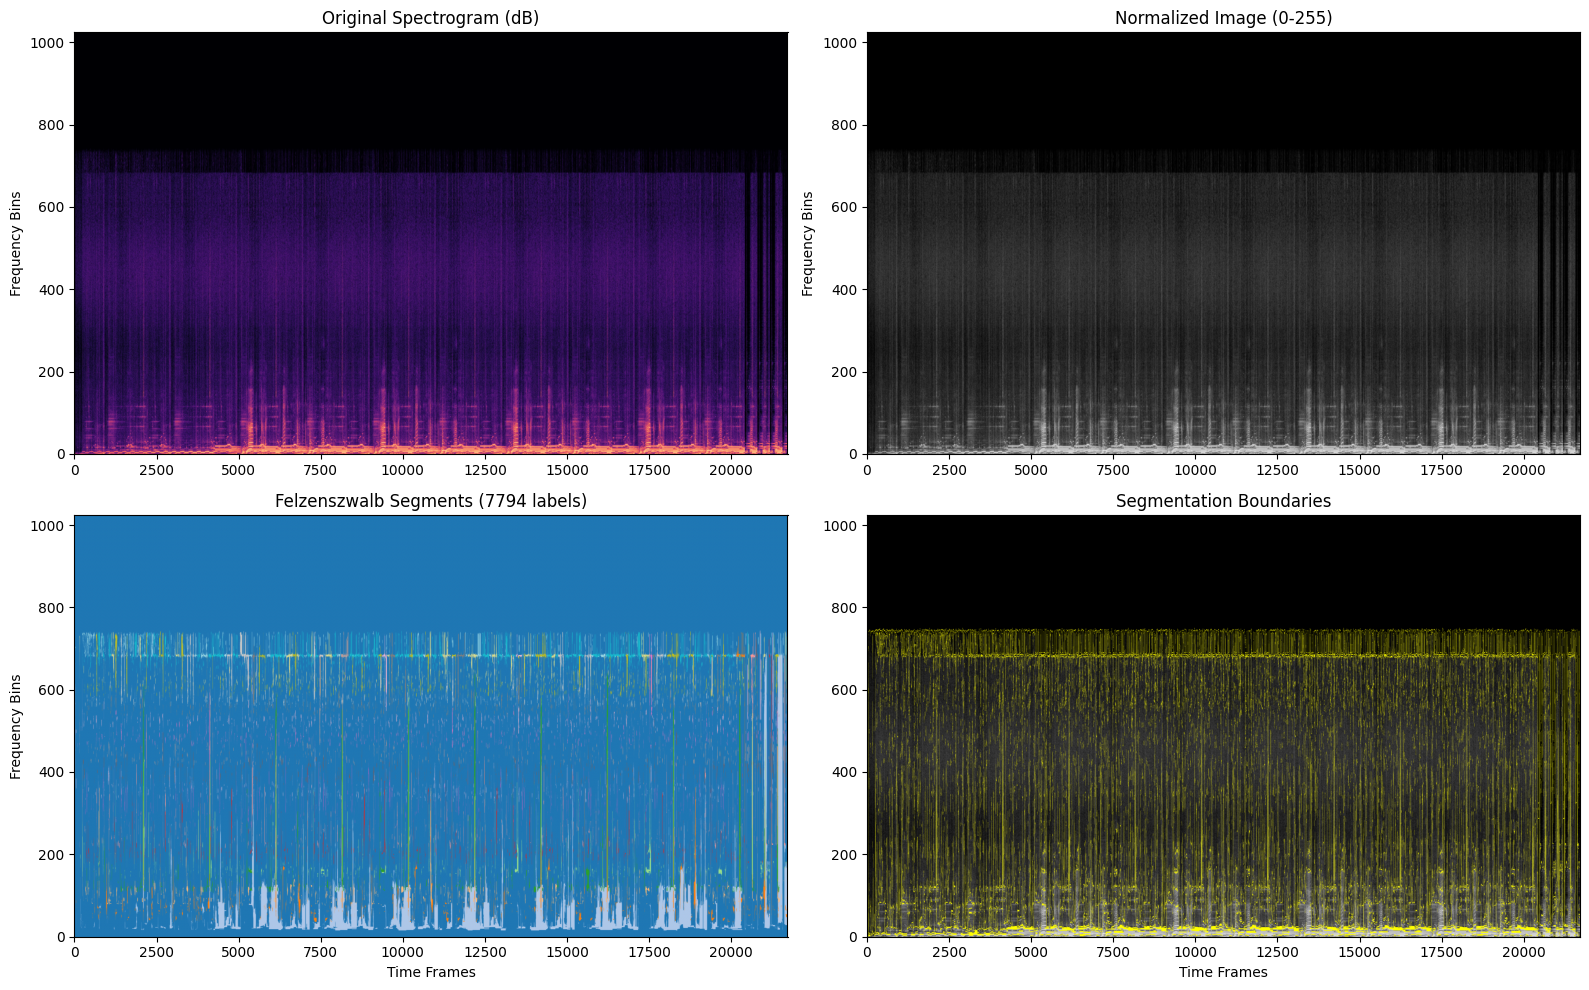


📊 SUMMARY:
   ⏱️  Processing time: 171.87s
   🧩 Total labels found: 7794
   🧩 Label regions processed (kept + filtered): 7794
   ❌ Filtered out: 7715
      └─ By time (< 0.5s duration): 7050
      └─ By time (empty): 0
      └─ By energy (< 1.0e-03 ratio): 665
      └─ By area (< 200 pixels): 0
   ✅ Audio chunks saved: 79
   📁 Output directory: chunks_detailed_lowsky/
   🎵 Average chunk duration: 50.31s


In [5]:
import numpy as np
import librosa
import soundfile as sf
import os
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb, mark_boundaries
from skimage.util import img_as_ubyte
import time

def split_audio_felzenszwalb_2d(
    audio_path,
    output_dir="chunks_detailed_{song_path.split('/')[-1].split('.')[0]}",
    n_fft=2048,
    hop_length=512,
    scale=150,
    sigma=3,
    min_size=20,
    min_area_pixels=200,
    min_time_seconds=0.1,
    min_energy_ratio=1e-4,
    max_shapes=None,
):
    """
    🎨 TRUE 2D FELZENSZWALB AUDIO SEGMENTATION (no connected-components)

    This function treats audio spectrograms like images and segments them into irregular 2D shapes.
    Unlike traditional time-based chunking, this extracts spectral "objects" from music.

    HOW IT WORKS:
    1) Compute STFT (frequency × time matrix)
    2) Treat magnitude spectrogram as a grayscale image
    3) Run Felzenszwalb segmentation to get label regions
    4) For EACH LABEL (as a whole), reconstruct its audio by masking the original STFT
    5) Save each label’s audio as its own file

    PARAMETERS:
    - n_fft: Frequency resolution (higher = more freq detail, less time detail)
    - hop_length: Time resolution (lower = more time detail, less freq detail)
    - scale/sigma/min_size: Felzenszwalb controls
    - min_area_pixels / min_time_seconds / min_energy_ratio: filters to skip tiny/short/quiet labels
    """
    start_time = time.time()
    os.makedirs(output_dir, exist_ok=True)

    print(f"🎵 LOADING AUDIO: {audio_path}")

    # 1) Load audio
    y, sr = librosa.load(audio_path, sr=None)
    duration = len(y) / sr
    print(f"   ⏱️  Duration: {duration:.2f}s, Sample Rate: {sr}Hz")

    # 2) Complex STFT and magnitude
    print(f"📊 COMPUTING STFT...")
    print(f"   🔧 n_fft={n_fft}, hop_length={hop_length}")
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window="hann", center=True)
    S = np.abs(D)  # (freq_bins, time_frames)
    freq_bins, time_frames = S.shape
    print(f"   📏 Spectrogram shape: {freq_bins} freq × {time_frames} time")

    # 3) Log scale + normalize to 0..255 for segmentation
    print(f"🎨 PREPARING IMAGE FOR SEGMENTATION...")
    S_db = librosa.amplitude_to_db(S + 1e-12, ref=np.max)
    S_db_norm = (S_db - S_db.min()) / max(1e-12, (S_db.max() - S_db.min()))
    img = img_as_ubyte(S_db_norm)  # 2D grayscale image
    print(f"   🖼️  Image range: {img.min()}-{img.max()} (8-bit grayscale)")

    # 4) Felzenszwalb segmentation on 2D spectrogram image
    print(f"🧩 RUNNING FELZENSZWALB SEGMENTATION...")
    print(f"   ⚙️  scale={scale}, sigma={sigma}, min_size={min_size}")
    segments = felzenszwalb(img, scale=scale, sigma=sigma, min_size=min_size)
    unique_labels = np.unique(segments)
    print(f"   🎯 Found {len(unique_labels)} initial segments (labels)")

    # 5) Process each label as a single region (no CC)
    print(f"🔍 EXTRACTING 2D SHAPES (one per label)...")
    total_energy = float(S.sum()) + 1e-12
    T = S.shape[1]
    times = librosa.frames_to_time(np.arange(T), sr=sr, hop_length=hop_length)

    saved_paths = []
    shape_index = 0
    filtered_shapes = 0
    filtered_by_area = 0
    filtered_by_energy = 0
    filtered_by_time = 0
    filtered_by_time_empty = 0

    for lab_idx, lab in enumerate(unique_labels):
        mask_lab = (segments == lab)          # use the label mask directly
        comp_mask = mask_lab                  # no connected-components; treat whole label as one

        # Filter 1: Time span too short
        time_mask = np.any(comp_mask, axis=0)
        min_time_frames = int(min_time_seconds * sr / hop_length)
        if time_mask.sum() < min_time_frames:
            filtered_shapes += 1
            filtered_by_time += 1
            continue

        # Filter 2: Energy too low
        energy = float(S[comp_mask].sum())
        energy_ratio = energy / total_energy
        if energy_ratio < min_energy_ratio:
            filtered_shapes += 1
            filtered_by_energy += 1
            continue

        # Filter 3: Area too small  
        area = int(comp_mask.sum())
        if area < min_area_pixels:
            filtered_shapes += 1
            filtered_by_area += 1
            continue

        # Calculate shape boundaries
        t0 = int(np.argmax(time_mask))
        t1 = int(len(time_mask) - np.argmax(time_mask[::-1]) - 1)
        freq_mask = np.any(comp_mask, axis=1)
        f0 = int(np.argmax(freq_mask))
        f1 = int(len(freq_mask) - np.argmax(freq_mask[::-1]) - 1)

        time_span = times[t1] - times[t0] if t1 > t0 else 0
        freq_span = f1 - f0 + 1

        # 🎵 RECONSTRUCT AUDIO: Mask the complex STFT with this label region
        D_masked = D * comp_mask.astype(D.dtype)
        y_rec = librosa.istft(D_masked, hop_length=hop_length, length=len(y))

        # Slice to the time span of this shape for a concise chunk
        start_samp = int(times[t0] * sr)
        end_samp = min(len(y), int(times[min(t1 + 1, T - 1)] * sr))
        y_seg = y_rec[start_samp:end_samp]
        if y_seg.size == 0:
            filtered_shapes += 1
            filtered_by_time_empty += 1
            continue

        # Normalize to avoid clipping
        peak = np.max(np.abs(y_seg))
        if peak > 0:
            y_seg = 0.98 * y_seg / peak

        shape_index += 1
        filename = f"felzen_shape_{shape_index:03d}_t{(t1 - t0 + 1)}_f{freq_span}.wav"
        out_path = os.path.join(output_dir, filename)
        sf.write(out_path, y_seg, sr)
        saved_paths.append(out_path)

        print(f"   🎵 Shape {shape_index:2d}: {time_span:.2f}s × {freq_span:3d}bins, energy={energy_ratio:.1e} → {filename}")

        if max_shapes is not None and shape_index >= max_shapes:
            break

    # 6) Create and display visualization
    print(f"📊 CREATING VISUALIZATIONS...")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Original spectrogram
    axes[0,0].imshow(S_db, aspect='auto', origin='lower', cmap='magma')
    axes[0,0].set_title('Original Spectrogram (dB)')
    axes[0,0].set_ylabel('Frequency Bins')

    # Normalized image for segmentation
    axes[0,1].imshow(img, aspect='auto', origin='lower', cmap='gray')
    axes[0,1].set_title('Normalized Image (0-255)')
    axes[0,1].set_ylabel('Frequency Bins')

    # Segmentation labels
    axes[1,0].imshow(segments, aspect='auto', origin='lower', cmap='tab20')
    axes[1,0].set_title(f'Felzenszwalb Segments ({len(unique_labels)} labels)')
    axes[1,0].set_xlabel('Time Frames')
    axes[1,0].set_ylabel('Frequency Bins')

    # Boundaries overlay
    boundary_img = mark_boundaries(np.dstack([S_db_norm]*3), segments)
    axes[1,1].imshow(boundary_img, aspect='auto', origin='lower')
    axes[1,1].set_title('Segmentation Boundaries')
    axes[1,1].set_xlabel('Time Frames')

    plt.tight_layout()
    viz_path = os.path.join(output_dir, "felzenszwalb_analysis.png")
    plt.savefig(viz_path, dpi=160, bbox_inches='tight')
    print(f"   💾 Saved visualization: {viz_path}")
    plt.show()

    # Summary statistics
    total_time = time.time() - start_time
    print(f"\n📊 SUMMARY:")
    print(f"   ⏱️  Processing time: {total_time:.2f}s")
    print(f"   🧩 Total labels found: {len(unique_labels)}")
    print(f"   🧩 Label regions processed (kept + filtered): {shape_index + filtered_shapes}")
    print(f"   ❌ Filtered out: {filtered_shapes}")
    print(f"      └─ By time (< {min_time_seconds}s duration): {filtered_by_time}")
    print(f"      └─ By time (empty): {filtered_by_time_empty}")
    print(f"      └─ By energy (< {min_energy_ratio:.1e} ratio): {filtered_by_energy}")
    print(f"      └─ By area (< {min_area_pixels} pixels): {filtered_by_area}")
    print(f"   ✅ Audio chunks saved: {shape_index}")
    print(f"   📁 Output directory: {output_dir}/")
    if saved_paths:
        print(f"   🎵 Average chunk duration: {np.mean([len(sf.read(p)[0])/sr for p in saved_paths[:5]]):.2f}s")
    else:
        print(f"   🎵 Average chunk duration: n/a")

    return saved_paths

# 🚀 RUN THE SEGMENTATION
print("🎨 STARTING FELZENSZWALB 2D AUDIO SEGMENTATION")
print("=" * 60)
song_path = "clips/lowsky.mp3"
shapes = split_audio_felzenszwalb_2d(
    song_path,
    output_dir=f"chunks_detailed_{song_path.split('/')[-1].split('.')[0]}",
    scale=150,      # Lower = more segments
    sigma=3,        # Lower = sharper boundaries
    min_size=20,    # Larger = fewer tiny segments
    max_shapes=100,  # Limit output for testing
    min_area_pixels=200,
    min_time_seconds=0.5,  # Minimum duration in seconds
    min_energy_ratio=1e-3
)